# Initial Analysis of Great Schools & 2010-2011 Exam Result Data

In [2]:
%matplotlib inline

##Code from Michael for accessing data

import pymysql
import pandas.io.sql as psql

import json
import numpy as np
import networkx as nx
import requests
from pattern import web
import matplotlib.pyplot as plt

import codecs
import requests.exceptions
import urllib2 
import htmllib
import pandas as pd
from BeautifulSoup import BeautifulSoup as Soup


# returns a connection to our MySQL db
def mysql_connect():
    
    cnx = pymysql.connect(host='cs109instance.ccikshmkulj7.us-east-1.rds.amazonaws.com', 
                           port=3306, 
                           user='samb', 
                           passwd='samb', 
                           db='cs109gs')
    this_cursor = cnx.cursor(pymysql.cursors.DictCursor)
    return cnx, this_cursor

# close cursor and MySQL connection
def mysql_disconnect(cnx, cursor):
    cursor.close()
    cnx.close() # close db connection
    
# get data from mysql db
def get_mysql_data(sql, data_id):
    cnx, cursor = mysql_connect()
    cursor.callproc(sql, (data_id,))
    
    if (cursor.rowcount > 0):
        df = pd.DataFrame(cursor.fetchall())
        mysql_disconnect(cnx, cursor)# close db connection
        return df
    else:
        print "no rows returned"
    return None

# return all reviews for one school gsid (denormalized, i.e. with the associated school data repeated per review)
def get_reviews_gsid(gsid):
    sql = 'school_reviews_by_gsid'
    return get_mysql_data(sql, gsid)

# return racial composition data for one school gsid 
def get_race_gsid(gsid):
    sql = 'school_race_by_gsid'
    return get_mysql_data(sql, gsid)

# return all reviews for one school ncesid (denormalized)
def get_reviews_ncesid(ncesid):
    sql = 'school_reviews_by_ncesid'
    return get_mysql_data(sql, ncesid)

# return all reviews for one school ncesid (denormalized)
def get_reviews_districtncesid(districtncesid):
    sql = 'school_reviews_by_districtncesid'
    return get_mysql_data(sql, districtncesid)

# return all reviews for one state (denormalized)
def get_reviews_state(state):
    sql = 'school_reviews_by_state'
    return get_mysql_data(sql, state)

# note the psql syntax: returns all schools / reviews in db (as of 11/16 only for LA county)
def get_all_reviews():
    cnx, cursor = mysql_connect()
    sql = 'call school_reviews' 
    df = psql.frame_query(sql, cnx)
    mysql_disconnect(cnx, cursor)
    return df

## 1. Exploring California

We scrapped California data while negotiating with Great Schools on obtaining data for research.  This section covers some initial exploration we did to get comfortable with the data.

Question we needed to answer: is there evidence that stars vary with exam results? If not, no one will believe it.

Following JD initial analysis will use data from LA - California as a test case

In [2]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

Start by merging gs data and exam data from 2010-2011

In [180]:
##Read gs data
la_list = pd.read_csv("/Users/sambarrows/Dropbox/greatschools - share/data/reviewsdetailed/1_california-los-angeles.csv")
#la_revs = pd.read_csv("/Users/sambarrows/Dropbox/greatschools - share/data/reviewsdetailed/reviews-california-los-angeles.csv")

##Drop obs with nan in ncesid
la_list_nonan = la_list[-pd.isnull(la_list['ncesid'])]

##Read in Math exam results data for 2010-2011
ca_math  = pd.read_csv("/Users/sambarrows/Dropbox/greatschools - share/data/examresults/California_Math_1011.csv")
#print ca_math.columns.tolist()

##Select just the nces id column ('ncessch'), the percentage of students in a school that score at or above 
##proficient, and the school name
ca_math_red = ca_math[['ncessch', 'ALL_MTH00pctprof_1011', 'schnam10']]

##Add zeros to make ncessch 12 figures
ca_math_red['ncessch12'] = ca_math_red.apply(lambda x: '%12.12i' % x['ncessch'], axis=1)

##Merge gs data with math exam results data
la_ful = pd.merge(la_list_nonan, ca_math_red, left_on='ncesid', right_on='ncessch12')

##Take a look at drops drops
#print la_list.shape
#print sum(pd.isnull(la_list['ncesid']))
#print la_list_nonan.shape
#print ca_math.shape
#print la_ful.shape

##Why have over 200 schools failed to find ncessch match? Take a look schooltypes
la_mergefail = la_list_nonan[-la_list_nonan['ncesid'].isin(la_ful['ncessch12'])]
print 'total failed matches: ' + str(la_mergefail.shape[0])
print 'private schools in failed matches: ' + str(sum(la_mergefail['type']=='Private'))
print 'charter schools in failed matches: ' + str(sum(la_mergefail['type']=='Charter'))
print 'public schools in failed matches: ' + str(sum(la_mergefail['type']=='Public'))
print

##What about the schools in gs dataset with nan in ncesid
la_list_nan = la_list[pd.isnull(la_list['ncesid'])]
print 'total nans in gs: ' + str(la_list_nan.shape[0])
print 'private schools with nan in gs: ' + str(sum(la_list_nan['type']=='Private'))
print 'charter schools with nan in gs: ' + str(sum(la_list_nan['type']=='Charter'))
print 'public schools with nan in gs: ' + str(sum(la_list_nan['type']=='Public'))

total failed matches: 252
private schools in failed matches: 222
charter schools in failed matches: 13
public schools in failed matches: 17

total nans in gs: 491
private schools with nan in gs: 470
charter schools with nan in gs: 16
public schools with nan in gs: 5


Most of the schools that have nan for ncesid are private schools. Likewise, most of hte schools failing to match with exam results are private schools. The other schools failing to match could easily be explained by new schools opening, schools restructuring etc. 

It's worth noting that for the LA private schools I checked, gs didn't have test results. Private schools can choose which exams to use and are not required to submit results: http://www.greatschools.org/find-a-school/defining-your-ideal/1173-comparing-private-public-school-test-scores.gs?page=all

This seemed like a lot of private schools to me, but apparently there are 1300 in LA County: http://www.privateschoolreview.com/county_private_schools/stateid/CA/county/6037

I think we may be missing a lot of public schools. According to Wikipedia the LA Unified School distirct contains 1124 schools:
http://en.wikipedia.org/wiki/Los_Angeles_Unified_School_District

Of the 465 that we have, lets see if there's any sign of a relationship between performance and star rating.

(414, 24)


[0, 6, 0, 100]

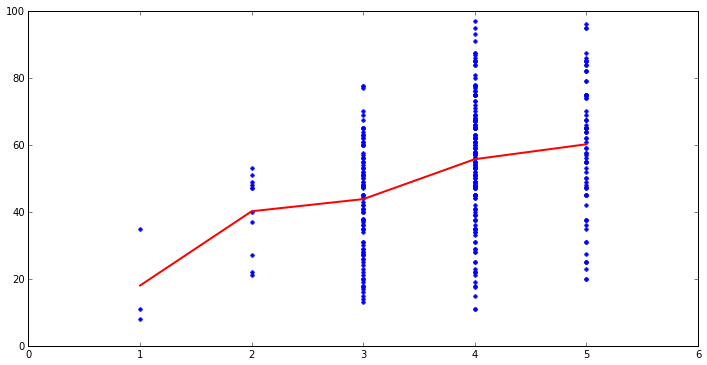

In [173]:
##Percent proficient in math is in categories, and with some non-numeric entries. Tidy it up a bit (rough job at this 
##stage) to make plotable

#print la_ful['ALL_MTH00pctprof_1011']
math_score = []
for x in la_ful['ALL_MTH00pctprof_1011']:
    try:
        int(x)
        math_score.append(float(x))
    except ValueError:    
        try:
            int(x[:2])
            x = float(x[:2])
            if x%10 == 0:
                math_score.append(x+5)
            elif x%5 == 0:
                math_score.append(x+2.5)
            else:
                math_score.append(x)
        except ValueError:
            x = float('inf')/ float('inf')
            math_score.append(x)
la_ful['math_score'] = math_score       

##Drop NaNs (messing things up)
la_ful = la_ful[-pd.isnull(la_ful['parentrating'])]
la_ful = la_ful[-pd.isnull(la_ful['math_score'])]

##Convert parentrating to float (a couple of empty strings making problems)
parentrating = []
for x in la_ful['parentrating']:
    try:
        parentrating.append(float(x))
    except:
        parentrating.append(np.nan)
la_ful['parentrating'] = parentrating
la_ful = la_ful[-pd.isnull(la_ful['parentrating'])]
print la_ful.shape

##Get avs for each parentrating score
means = la_ful.groupby('parentrating').mean()

##Make plot
plt.figure(figsize=(12,6))
plt.plot(la_ful['parentrating'], la_ful['math_score'], '.', color='b', markersize=7)
plt.plot(means.index, means['math_score'], '-', color='r', linewidth=2)
plt.axis([0,6,0,100])

There does appear to be a positive relationship between parentrating and proportion of children "at or above proficient" in mathematics. However, given that we are down to 414 observations, I am cautious about giving too much weight to this finding.

Having obtained the full dataset, we then ran some more analyses on California, with which we were now familiar, to make sure that everything looked ok.

### Compare schools using Glyphs: Los Angeles

We started by exploring the Lost Aneglese data, as this is what we were most familiar with. We wanted a quick sanity check to make sure everything was in order, and to see if any early patterns jumped out. We tried using glyphs to compare the average star ratings of different schools. Some examples are shown below. Unfortunately, this did not prove very informative.

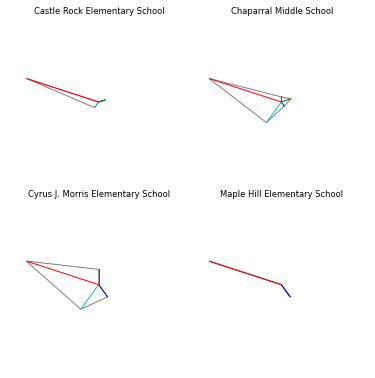

In [3]:
def make_glyph(ncesid, ax):
    """
    Create Glyph for school specified by ncesid. 
    Each of the 5 distances is the number of times a school received that rating.
    """
    ##Load school data
    df = get_reviews_ncesid(ncesid)
    df_stars = df[df['stars'] < 99]
    
    ##Get counts for numbers stars 
    count_stars = []
    for x in range(1,6):
        count_stars.append(list(df_stars['stars']).count(x))
    s = []
    for x in count_stars:
        s.append(x*5/float(max(count_stars)))
    
    ##Draw edges
    theta = [np.pi*2.5, np.pi*2.1, np.pi*1.7, np.pi*1.3, np.pi*2.9, np.pi*2.5]
    r = [s[0],s[1],s[2],s[3],s[4],s[0]]         
    ax.plot(theta, r, c='gray', linestyle='-')        
    
    ##Join each point to center
    colors = ['m','g','b','c','r']
    for i in range(0,len(theta)-1):
        if r[i] > 0:
            ax.plot([theta[i], 1], [r[i],0], color=colors[i])
            plt.axis('off')
    ax.set_title(df_stars['name'][0])
            
#plt.subplots(2, 2, subplot_kw=dict(polar=True))            
            
fig = plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 7})
ax1 = fig.add_subplot(221, polar=True)    
make_glyph('064128006833', ax1)
ax2 = fig.add_subplot(222, polar=True)
make_glyph('064128006834', ax2)
ax3 = fig.add_subplot(223, polar=True)
make_glyph('064128006836', ax3)
ax4 = fig.add_subplot(224, polar=True)
make_glyph('064128006839', ax4)
plt.show()     

### Take a look at schools in google maps, shading by stars: Los Angeles

We next used google maps to plot the location of schools. This was a useful sanity check and also gave some indication that schools in poorer neighborhoods may receive lower star ratings, wiht a few fed pins in Compton. However, there were no striking patterns and the visualizations colored pins was somewhat awkward.

In [ ]:
import pygmaps    #http://code.google.com/p/pygmaps/
import pandas as pd
#from IPython.display import HTML

schools = pd.read_csv('/Users/sambarrows/Dropbox/greatschools - share/data/schools/schools_LA_county.csv')
#print schools.head()
#print schools.shape
#print min(schools['lat'])
#print max(schools['lat'])
#print min(schools['lon'])
#print max(schools['lon'])
#lt.hist(schools['lat'])

schools=schools[schools.lat<35]
#print schools.shape

cent_lat=min(schools['lat']) + (max(schools['lat'])-min(schools['lat']))/float(2)
cent_lon=min(schools['lon']) + (max(schools['lon'])-min(schools['lon']))/float(2)

mymap = pygmaps.maps(cent_lat, cent_lon, 8)

for index, row in schools.iterrows():
    if row['parentrating']==1:
        mymap.addpoint(row['lat'], row['lon'], "#FF0000")
    elif row['parentrating']==2:
        mymap.addpoint(row['lat'], row['lon'], "#FFA500")
    elif row['parentrating']==3:
        mymap.addpoint(row['lat'], row['lon'], "#FFFF00")
    elif row['parentrating']==4:
        mymap.addpoint(row['lat'], row['lon'], "#00FFFF")
    elif row['parentrating']==4:
        mymap.addpoint(row['lat'], row['lon'], "#7FFF00")
    else:
        mymap.addpoint(row['lat'], row['lon'], "#CDC9C9")
        
map_url = '/Users/sambarrows/Dropbox/greatschools - share/SamBarrows/mymap.html'
mymap.draw(map_url)

<img src="files/ScreenshotLA.png">

## 2.  Exploring the entire dataset

Upon receiving the entire dataset, we explored several aspects of reviews.  Most statistics were performed in SQL and plotted in Powerpoint.

### Plot points for country, shading by stars

We decided to zoom out, and instead plot a point for every school in the country, again colored according to the star rating. This plot did not indicate any difference between rural schools and urban centers or across regions. However, having so many tops on top of each other may have been hiding patterns. We didn't have time to aggregate school data at the census tract level, for example, so for further geographical exploration we plotted at the state level.

In [9]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
from IPython.display import HTML
import urllib
thecode = open("rcode/plotpoints.R").read()
thehtml=highlight(thecode, PythonLexer(), HtmlFormatter())
HTML(thehtml)

<img src="files/alluspoints.png">

### How topics/ratings vary with wealth/income 

A central question that we wanted to explore was how ratings and topics varied with school affluence (measured by the percent of students on free and reduced price lunch (FRPL)) and with school performance (measure by distance from national mean percnt proficient, using the measure we constructed.

We first loaded the data and did a little tidying.

In [13]:
df = pd.read_csv('cs109_gs_regression_set_20131212.txt')
df.columns = ['name', 'state', 'type', 'frpl', 'top1', 'top2', 'z11', 'z12', 'stars', 'avg_topics']
##print df.head()
##print df.shape

df = df[df['frpl']<100]
##print df.shape

##plt.hist(df['z11'].unique())
##plt.xlabel('zscore 2011')
##plt.show()
df = df[df['z11']>-6]
##print df.shape
##plt.hist(df['z11'].unique())
##plt.xlabel('zscore 2011')
##plt.show()

##plt.hist(df['z12'].unique())
##plt.xlabel('zscore 2012')
##plt.show()

We then plotted the bivariate relationships between average star rating and FRPL from 2011 and 2012, school performance and FRPL, and school performance and FRPL. The figures below indicate that ratings are positively correlated with school performance, an imortant indication that there is signal in the data and not just noise. Again as expected, ratings are negatively correlated with FRPL

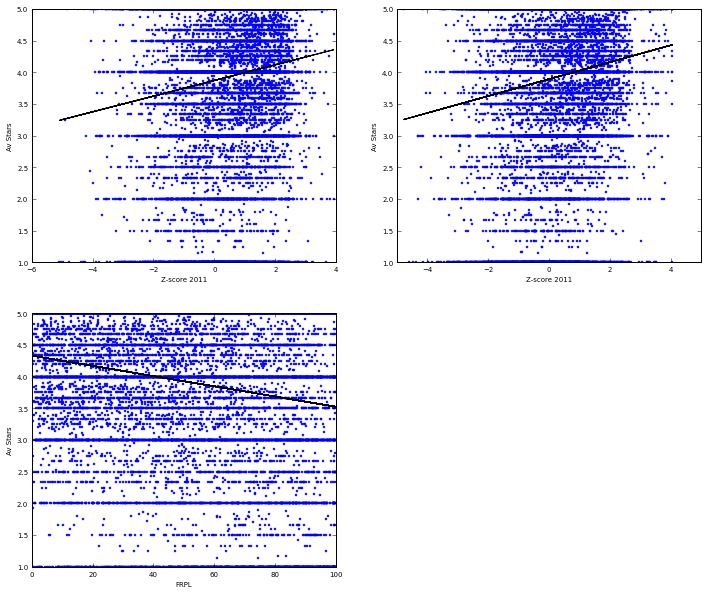

In [14]:
school_df = df.groupby(['name', 'state'])
star_list = school_df.apply(lambda x:np.mean(x['stars']))
z11_list = school_df.apply(lambda x:np.mean(x['z11']))
z12_list = school_df.apply(lambda x:np.mean(x['z12']))
frpl_list = school_df.apply(lambda x:np.mean(x['frpl'])) 

fig = plt.figure(figsize=(12,10))

def plot_stars(position, xlist, ylist, x_label, y_label):
    ax1 = fig.add_subplot(position)  
    m, b = np.polyfit(xlist,ylist,1)
    ax1.plot(xlist,ylist, '.', color='b', markersize=4)
    ax1.plot(xlist, m*xlist + b, '-', color='k', linewidth=1)
    ax1.set_ylabel(y_label)
    ax1.set_xlabel(x_label)
    
plot_stars(221, z11_list, star_list, 'Z-score 2011', 'Av Stars')
plot_stars(222, z12_list, star_list, 'Z-score 2011', 'Av Stars')
plot_stars(223, frpl_list, star_list, 'FRPL', 'Av Stars')

We next plot the relationship beween topics at the school level and both school performance and then FRPL. There was little indication of any relationship.

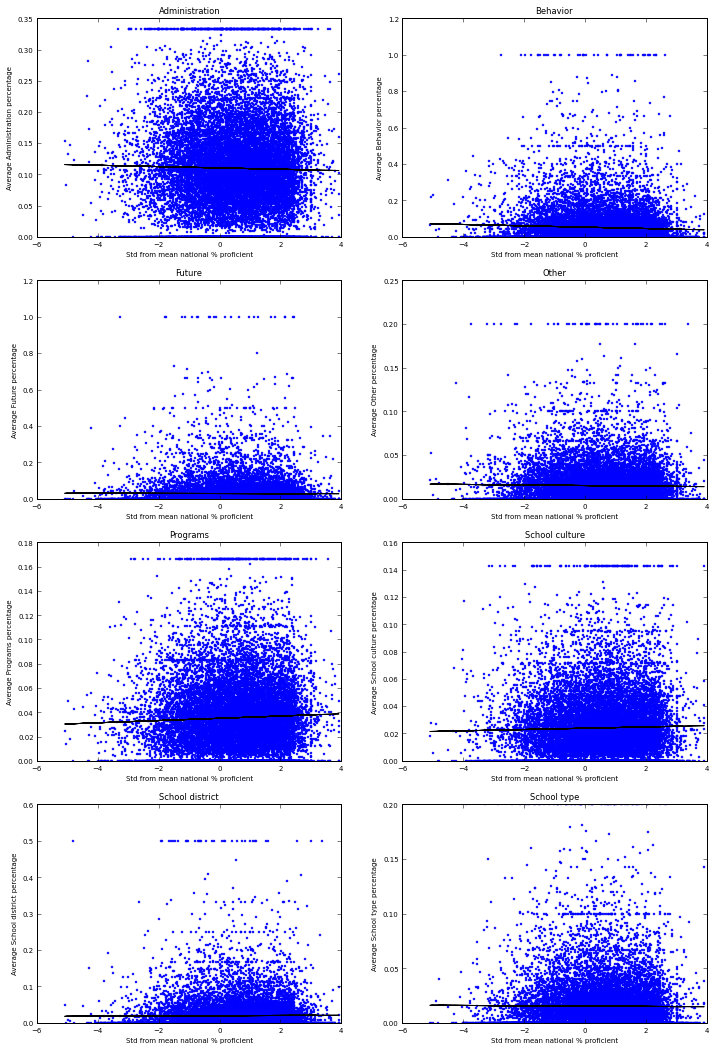

In [15]:
def plot_topic(position, name):
    topic_list = school_df.apply(lambda x:np.mean(x[x['top1']==name]['avg_topics']))
    ax1 = fig.add_subplot(position)  
    m, b = np.polyfit(z11_list,topic_list,1)
    ax1.plot(z11_list,topic_list, '.', color='b', markersize=4)
    ax1.plot(z11_list, m*z11_list + b, '-', color='k', linewidth=1)
    ax1.set_ylabel('Average ' + name + ' percentage')
    ax1.set_xlabel('Std from mean national % proficient')
    ax1.set_title(name)
    
fig = plt.figure(figsize=(12,18))
plot_topic(421, 'Administration')
plot_topic(422, 'Behavior')
plot_topic(423, 'Future')
plot_topic(424, 'Other')
plot_topic(425, 'Programs')
plot_topic(426, 'School culture')
plot_topic(427, 'School district')
plot_topic(428, 'School type')

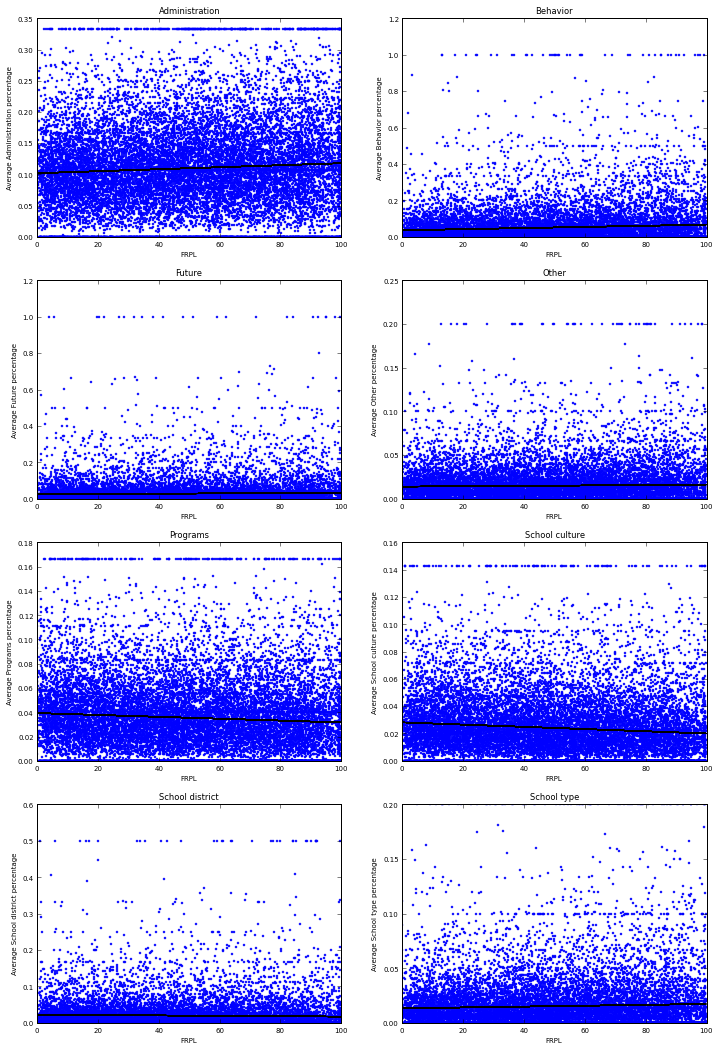

In [16]:
def plot_topic(position, name):
    topic_list = school_df.apply(lambda x:np.mean(x[x['top1']==name]['avg_topics']))
    ax1 = fig.add_subplot(position)  
    m, b = np.polyfit(frpl_list,topic_list,1)
    ax1.plot(frpl_list,topic_list, '.', color='b', markersize=4)
    ax1.plot(frpl_list, m*frpl_list + b, '-', color='k', linewidth=1)
    ax1.set_ylabel('Average ' + name + ' percentage')
    ax1.set_xlabel('FRPL')
    ax1.set_title(name)
    
fig = plt.figure(figsize=(12,18))
plot_topic(421, 'Administration')
plot_topic(422, 'Behavior')
plot_topic(423, 'Future')
plot_topic(424, 'Other')
plot_topic(425, 'Programs')
plot_topic(426, 'School culture')
plot_topic(427, 'School district')
plot_topic(428, 'School type')

### Distributions

We plotted the distribution of stars by a few dimensions.  Private schools appear to do better then public schools.  Charter schools sit between public and private schools.

<img src="files/img_explore_1.png">

Staff are surprisingly "reliable", i.e., they also give bad reviews.  Principals are the outliers, giving 5 star reviews about 90% of the time.  Among "customers" of schools, former students are the least happy (statistically significant).

<img src="files/img_explore_2.png">

We looked at the top words used in reviews about public, private, and charter schools.  Using word clouds, it is very difficult to see the differences between the schools.  This justifies our use of topics to garner more insights from the reviews.

<img src="files/img_explore_3.png">

Reviews data could be used to understand trends within a school, or in the education culture of the U.S. in general.  Below are several plots relating to single words trending over time from 2004 to 2013 by month.  The first, "safety", appears to be in decline, with a bump in 2007, and now appearing to be on the increase again, possibly instigated by recent school shootings.

<img src="files/img_explore_4.png">

With the Great Recession, budget and funding has been on the minds of policymakers and citizens alike.  Surprisingly, reviews mentioning "budget" declined during the stock market boom of 2005-7, but did not rise immediately at the market crash.  It appears to be a lag indicator of stock market declines.

<img src="files/img_explore_5.png">

Looking at individual reviews sparked interest in how people viewed Spanish as a foreign language and latin immigrants.  Surprisingly, plotting the word trend revealed an eerily close correlation between reviews mentioning "spanish" and the stock market.  While not causal, and possibly spurious, there may be underlying mechanisms that could be worth exploring in a future project.

<img src="files/img_explore_6.png">

Bullying and teen suicides are on the forefront of social issues confronting schools at the moment.  The peak of reviews mentioning "bully" correlates with Google trends for web searches in the U.S.  The rise in 2011 may have been instigated by teen suicides and Obama addressing bullying victims.

<img src="files/img_explore_7.png">

Using LDA, we can segment reviews by topics.  The largest proportion of reviews talked about school administration - principals, staff, teachers, policies and organization.  The next segment was about school programs, both curricular and extra curricular.  The third most common review topic was school culture.  Most of them were positive, accolading community sense in schools, but some were negative.

<img src="files/img_explore_8.png">

We made sure to keep the LDA neutral by keeping only nouns.  To cross topics with sentiment, we found that reviews about programs, school culture, and student future tended to be more positive, while reviews about administration, behavior, and other topics tended to be more negative.

<img src="files/img_explore_9.png">

We subdivide categories of reviews into finer categories.

<img src="files/img_explore_10.png">
<img src="files/img_explore_11.png">

Topics were averaged within each state, then clustered by k-means.  Skree-type plot was used to select number of clusters (3 clusters).  Then, we looked at which topics were overrepresented for each cluster.

<img src="files/img_explore_12.png">

Code for generating word cloud in R (using $wordcloud$ package)

In [2]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
from IPython.display import HTML
import urllib
thecode = open("rcode/topicsbystate v1.R").read()
thehtml=highlight(thecode, PythonLexer(), HtmlFormatter())
print "### Word cloud"
HTML(thehtml)

### Word cloud


Code for kmeans and map in R

In [4]:
thecode = open("rcode/map v1.R").read()
thehtml=highlight(thecode, PythonLexer(), HtmlFormatter())
print "### kmeans and US map"
HTML(thehtml)

### kmeans and US map
